In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from matplotlib import font_manager
for file in font_manager.findSystemFonts([r'C:\Users\crino\Downloads\Lato']):
    font_manager.fontManager.addfont(path=file)
plt.rcParams['font.family'] = 'Lato'

In [2]:
def thresh(mu, eps, α, m, v, f, α_m, r_s, r_i, ψ, p, γ, w):
    α_s = 1 - r_s * (1 - α_m)
    α_i = 1 - r_i * (1 - α_m)
    ψ_w = 1 - w * (1 - ψ)
    γ_p = 1 - p * (1 - γ)
    
    if α == 2:
        mean_a = ((1 - α) / (1 - eps**(1 - α))) * (-np.log(eps))
    else:
        mean_a = (1 - α) * (1 - eps**(2 - α)) / ((2 - α) * (1 - eps**(1 - α)))
    
    if α == 3:
        mean_a2 = ((1 - α) / (1 - eps**(1 - α))) * (-np.log(eps))
    else:
        mean_a2 = (1 - α) * (1 - eps**(3 - α)) / ((3 - α) * (1 - eps**(1 - α)))
    
    λ_t = 2 * mu * ((m * (1 - v * f) * α_s * α_i) * (mean_a * (ψ_w + γ_p) + np.sqrt(mean_a**2 * (ψ_w - γ_p)**2 + 4 * ψ_w * γ_p * mean_a2)))**(-1)
    return λ_t, mean_a

def act_thresh(eps, α, u):
    if u == 0:
        return eps
    elif u == 1:
        return 1
    
    α1 = 1 - α
    x = (u * (1 - np.power(eps, α1)) + np.power(eps, α1)) ** (1 / α1)
    return x

def ab_vax_thresh(mu, eps, α, m, v, f, f_u, f_d):
    t_f = act_thresh(eps, α, 1-f)
    n_rev_f = ((t_f**(1-α) - eps**(1-α))) / (1 - eps**(1-α))
    mean_a = (1 - α)*(1 - eps**(2-α)) / ((2-α) * (1 - eps**(1-α)))
    mean_a2 = (1 - α)*(1 - eps**(3-α)) / ((3-α) * (1 - eps**(1-α)))
    mean_a_f = (1 - α)*(t_f**(2-α) - eps**(2-α)) / ((2-α) * (1 - eps**(1-α)))
    mean2_a_f = (1 - α)*(t_f**(3-α) - eps**(3-α)) / ((3-α) * (1 - eps**(1-α)))

    v_rev_n = (1 - v * f_u) + v * (f_u - f_d) * n_rev_f
    v_rev_a = (1 - v * f_u) * mean_a + v * (f_u - f_d) * mean_a_f
    v_rev_a2 = (1 - v * f_u) * mean_a2 + v * (f_u - f_d) * mean2_a_f

    λ_t = mu * (m * (v_rev_a + np.sqrt(v_rev_n * v_rev_a2)))**(-1)
    return λ_t, mean_a

In [5]:
class datoni:
    
    def __init__(self, name):
        
        self.file_name = f"{name}"
        #self.file_path =f"C:\\Users\crino\Desktop\Thesis_ISI\Simulations\data_simulation\datafile{file_name}.csv"
        self.file_path = f"C:\\Users\\crino\\Desktop\\Thesis_ISI\\Simulations\\data_simulation\\datafile{name}.csv"
        self.datuni = pd.read_csv(self.file_path)
        self.lambdas = self.datuni.iloc[0]
        self.sim_data = self.datuni.iloc[1:]
        self.thresh = self.datuni.iloc[0,6]
        
    
    def media(self):
        #qua devo fare la media
        media = self.sim_data.mean() / 100000
        return media
        
    def varia(self):
        N = 100000
        r_mean = self.media()
        df_sq = (self.sim_data / N) ** 2
        r_mean2 = df_sq.mean()
        r_var_t = np.sqrt(np.abs(r_mean2 - (r_mean ** 2))) / r_mean
        r_var = r_var_t / np.max(r_var_t)
        return r_var

class plottoni:
    
    def __init__(self, pname, color, marker):
        self.pname = f"{pname}"
        self.color = f"{color}"
        self.marker = f"{marker}"
        self.pfile_name = f"{pname}"
        self.pfile_path =f"C:\\Users\crino\Desktop\Thesis_ISI\Simulations\data_simulation\param_{self.pfile_name}.csv"
        self.params = pd.read_csv(self.pfile_path)
        self.p = self.params["p"][0]
        #print(self.p)
        self.w = self.params["w"][0]
        #print(self.w)
        self.f_u = self.params["f_u"][0]
        self.f_d = self.params["f_d"][0]
        self.f = self.params["f"][0]
        self.v = self.params["v"][0]
        self.α = self.params["α"][0]
        self.eps = self.params["eps"][0]
        self.mu = self.params["mu"][0]
        self.m = self.params["m"][0]
        self.datoni = datoni(name = self.pname)
        self.erre = [float(column) for column in self.datoni.datuni.columns]
        self.true_thresh = ab_vax_thresh(self.mu, self.eps, self.α, self.m, self.v, self.f, self.f_u, self.f_d)[0]
    
    def plotto_m(self, axs):
        
        axs.plot(self.datoni.lambdas, self.datoni.media(), color=self.color, marker=self.marker , alpha=0.7, label=f"$v = {self.v}$")
        axs.vlines(self.true_thresh, ymin = 0, ymax = 0.7,  colors = self.color, linestyle = "-.")
        lower_bound, upper_bound = np.percentile(self.datoni.sim_data/100000, [2.5, 97.5], axis = 0)
        axs.fill_between(x=self.datoni.lambdas, y1=lower_bound, y2=upper_bound, color=self.color, alpha =0.2, linewidth = 0)
        axs.scatter(self.datoni.lambdas, self.datoni.media(), color=self.color, marker=self.marker, edgecolors='black', linewidth=0.4)
        
        axs.set_xlabel("$\lambda$")
        axs.set_ylabel("$r_{\infty}$")
        

    def plotto_v(self, axs): 
        axs.plot(self.datoni.lambdas, self.datoni.varia(), color=self.color, marker=self.marker , alpha=0.7, label=f"$v = {self.v}$")
        axs.vlines(self.true_thresh, ymin = 0, ymax = 1,  colors = self.color, linestyle = "-.")
        axs.scatter(self.datoni.lambdas, self.datoni.varia(), color=self.color, marker=self.marker, edgecolors='black', linewidth=0.4)
        
        axs.set_xlabel("$\lambda$")
        axs.set_ylabel("$σ_{r_∞}/σ_{max}$")

In [4]:
class datoni:
    
    def __init__(self, name):
        
        self.file_name = f"{name}"
        #self.file_path =f"C:\\Users\crino\Desktop\Thesis_ISI\Simulations\data_simulation\datafile{file_name}.csv"
        self.file_path = f"C:\\Users\\crino\\Desktop\\Thesis_ISI\\Simulations\\data_simulation\\datafile{name}.csv"
        self.datuni = pd.read_csv(self.file_path)
        self.lambdas = self.datuni.iloc[0]
        self.sim_data = self.datuni.iloc[1:]
        self.thresh = self.datuni.iloc[0,6]
        
    
    def media(self):
        #qua devo fare la media
        media = self.sim_data.mean() / 100000
        return media
        
    def varia(self):
        N = 100000
        r_mean = self.media()
        df_sq = (self.sim_data / N) ** 2
        r_mean2 = df_sq.mean()
        r_var_t = np.sqrt(np.abs(r_mean2 - (r_mean ** 2))) / r_mean
        r_var = r_var_t / np.max(r_var_t)
        return r_var

class plottoni:
    
    def __init__(self, pname, color, marker):
        self.pname = f"{pname}"
        self.color = f"{color}"
        self.marker = f"{marker}"
        self.pfile_name = f"{pname}"
        self.pfile_path =f"C:\\Users\crino\Desktop\Thesis_ISI\Simulations\data_simulation\param_{self.pfile_name}.csv"
        self.params = pd.read_csv(self.pfile_path)
        self.p = self.params["p"][0]
        #print(self.p)
        self.w = self.params["w"][0]
        #print(self.w)
        self.f_u = self.params["f_u"][0]
        self.f_d = self.params["f_d"][0]
        self.f = self.params["f"][0]
        self.v = self.params["v"][0]
        self.α = self.params["α"][0]
        self.eps = self.params["eps"][0]
        self.mu = self.params["mu"][0]
        self.m = self.params["m"][0]
        self.datoni = datoni(name = self.pname)
        self.erre = [float(column) for column in self.datoni.datuni.columns]
        self.true_thresh = ab_vax_thresh(self.mu, self.eps, self.α, self.m, self.v, self.f, self.f_u, self.f_d)[0]
    
    def plotto_m(self, axs):
        
        axs.plot(self.datoni.lambdas, self.datoni.media(), color=self.color, marker=self.marker , alpha=0.7, label=f"$v = {self.v}$")
        axs.vlines(self.true_thresh, ymin = 0, ymax = 0.7,  colors = self.color, linestyle = "-.")
        lower_bound, upper_bound = np.percentile(self.datoni.sim_data/100000, [2.5, 97.5], axis = 0)
        axs.fill_between(x=self.datoni.lambdas, y1=lower_bound, y2=upper_bound, color=self.color, alpha =0.2, linewidth = 0)
        axs.scatter(self.datoni.lambdas, self.datoni.media(), color=self.color, marker=self.marker, edgecolors='black', linewidth=0.4)
        
        axs.set_xlabel("$\lambda$")
        axs.set_ylabel("$r_{\infty}$")
        

    def plotto_v(self, axs): 
        axs.plot(self.datoni.lambdas, self.datoni.varia(), color=self.color, marker=self.marker , alpha=0.7, label=f"$v = {self.v}$")
        axs.vlines(self.true_thresh, ymin = 0, ymax = 1,  colors = self.color, linestyle = "-.")
        axs.scatter(self.datoni.lambdas, self.datoni.varia(), color=self.color, marker=self.marker, edgecolors='black', linewidth=0.4)
        
        axs.set_xlabel("$\lambda$")
        axs.set_ylabel("$σ_{r_∞}/σ_{max}$")

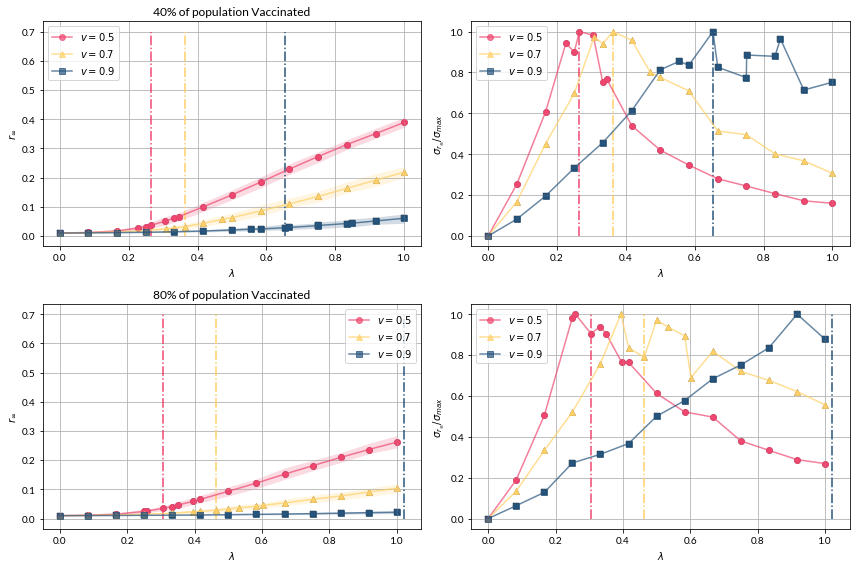

In [8]:
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

rows = 2
cols = 3

# Create an empty matrix to store instances of datoni
pmatrix = [[None] * cols for _ in range(rows)]
colori = ["#ef476f", "#ffd166", "#26547c"]
pallini = ["o", "^",  "s"]
fs = ["40", "80"]
vs = ["50", "70", "90"]
# Create instances of datoni for each element in the matrix
for i in range(rows):
    for j in range(cols):
        # Create an instance of datoni and store it in the matrix
        
        pmatrix[i][j] = plottoni(pname = f"_ab_rvax_{fs[i]}_{vs[j]}", color = colori[j], marker = pallini[j])
        pmatrix[i][j].plotto_m(axs[i][0])
        pmatrix[i][j].plotto_v(axs[i][1])
        
for ax in axs.flatten():
    ax.grid(True)
    ax.legend()
axs[0][0].legend(loc = "upper left")
axs[0][0].set_title("40% of population Vaccinated")
axs[1][0].set_title("80% of population Vaccinated")

file_path = r"C:\Users\crino\Desktop\Thesis_ISI\Simulations\images_plot\ab_rvax_plot.png"

# Save the figure with specified DPI
plt.savefig(file_path, dpi=300) 

    
plt.tight_layout()
plt.show()